Import libraries

In [1]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
from pathlib import Path
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

Retrieve data from the server

In [2]:
# see the available projects
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [3]:
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test']


In [4]:
# optionally, remove some animals
animals_to_remove = ['test']
for animal in animals_to_remove:
    if animal in animals:
        animals.remove(animal)
        print(f"Removed {animal} from the list of animals.")
    else:
        print(f"{animal} not found in the list of animals.")

Removed test from the list of animals.


In [5]:
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

receiving incremental file list
ACV001.csv

sent 6,139 bytes  received 19,628 bytes  17,178.00 bytes/sec
total size is 1,122,432  speedup is 43.56
receiving incremental file list
ACV002.csv

sent 6,271 bytes  received 15,625 bytes  8,758.40 bytes/sec
total size is 1,116,102  speedup is 50.97
receiving incremental file list
ACV003.csv

sent 6,901 bytes  received 20,611 bytes  18,341.33 bytes/sec
total size is 1,402,880  speedup is 50.99
receiving incremental file list
ACV004.csv

sent 5,515 bytes  received 15,377 bytes  13,928.00 bytes/sec
total size is 895,809  speedup is 42.88
receiving incremental file list
ACV005.csv

sent 7,225 bytes  received 63,077 bytes  46,868.00 bytes/sec
total size is 1,765,178  speedup is 25.11
receiving incremental file list
ACV006.csv

sent 7,453 bytes  received 38,512 bytes  30,643.33 bytes/sec
total size is 1,729,041  speedup is 37.62
receiving incremental file list
ACV007.csv

sent 6,241 bytes  received 24,597 bytes  12,335.20 bytes/sec
total size is 1,

Read the data

In [6]:
df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)

Loaded data for ACV001.
Loaded data for ACV002.
Loaded data for ACV003.
Loaded data for ACV004.
Loaded data for ACV005.
Loaded data for ACV006.
Loaded data for ACV007.
Loaded data for ACV008.
Loaded data for ACV009.
Loaded data for ACV010.


In [94]:
# # create a profile report
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# # save the report to a file
# output_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("reports") / Path("profiling_report.html")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# profile.to_file(output_file=str(output_path))
# # print the path to the report
# print(f"Profiling report saved to {output_path}.")

Fill missing values and add some columns

In [7]:
df = dft.analyze_df(df)

Trials per day and evolution of performance

In [8]:
# plot the number of trials per day
df_to_plot = df.groupby(['subject', 'year_month_day', 'current_training_stage']).size().reset_index(name='trials')
# add also the correct percentage
df_to_plot_correct = df.groupby(['subject', 'year_month_day', 'current_training_stage'])[['correct', 'miss_trial']].mean().reset_index()
# merge the two dataframes
df_to_plot = df_to_plot.merge(df_to_plot_correct, on=['subject', 'year_month_day', 'current_training_stage'])
# sort the dataframe by date
df_to_plot = df_to_plot.sort_values(by=['year_month_day'])
# replace the current_training_stage values with more readable ones
df_to_plot['current_training_stage'] = df_to_plot['current_training_stage'].replace({
    'not saved': 'Habituation',
})

/tmp/ipykernel_1354/1223877287.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/tmp/ipykernel_1354/1223877287.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/tmp/ipykernel_1354/1223877287.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')


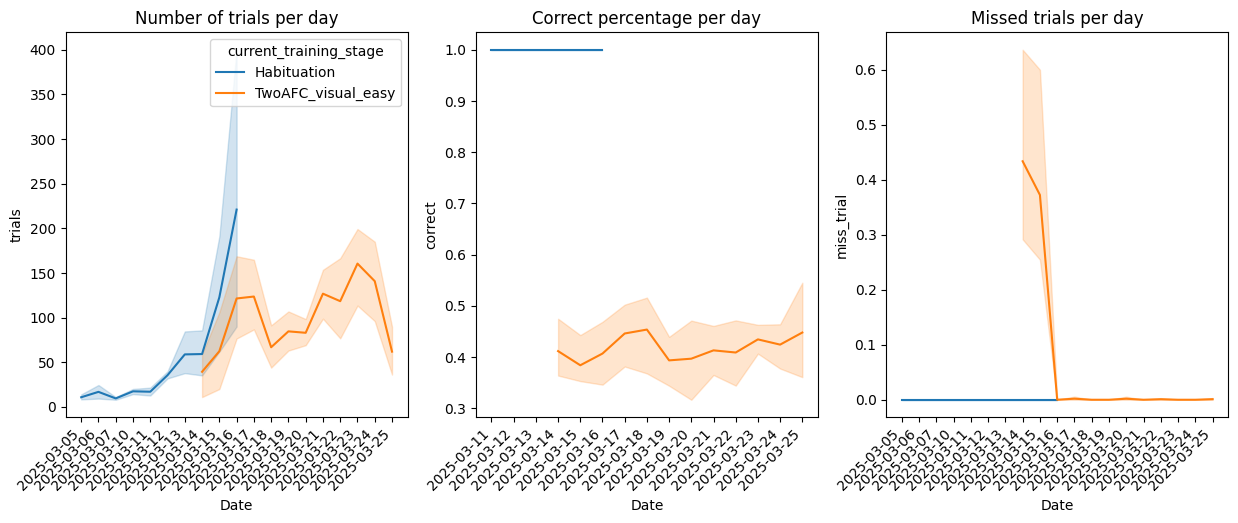

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
sns.lineplot(data=df_to_plot, x='year_month_day', y='trials', hue='current_training_stage', ax=axs[0])
axs[0].set_title('Number of trials per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='correct', hue='current_training_stage', ax=axs[1])
axs[1].set_title('Correct percentage per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='miss_trial', hue='current_training_stage', ax=axs[2])
axs[2].set_title('Missed trials per day')
for ax in axs:
    ax.set_xlabel('Date')
    # tilt the x-axis labels and align them to the right
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
# remove legends of 1 and 2
for ax in axs[1:]:
    ax.legend_.remove()


plt.show()

In [10]:
# Correct percentage per total trial in 2AFC. Separate also alternating and repeating
# TODO: move them to the other repo? and add them to df
df_perf_list = []
for mouse in animals:
    df_mouse = df[np.logical_and(df['subject'] == mouse, df['current_training_stage'] == 'TwoAFC_visual_easy')]
    df_to_append = dft.get_performance_through_trials(df_mouse)
    df_to_append = dft.get_repeat_or_alternate_performance(df_to_append)
    df_perf_list.append(df_to_append)

df_perf = pd.concat(df_perf_list, ignore_index=True)

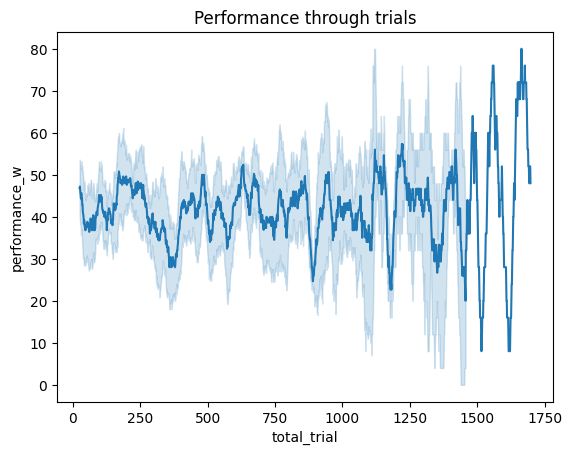

In [11]:
# plot the performance through trials
sns.lineplot(data=df_perf, x='total_trial', y='performance_w')
plt.title('Performance through trials')
plt.show()

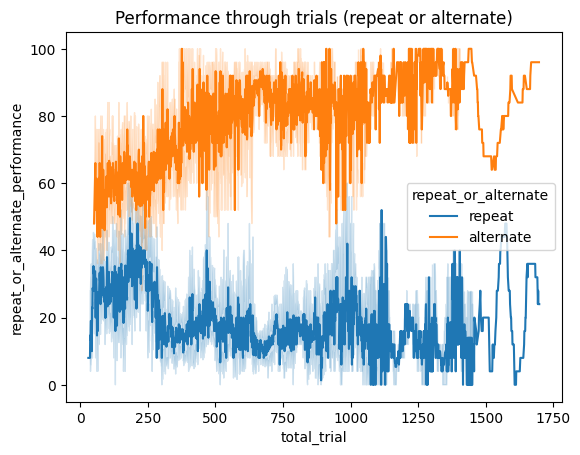

In [12]:
# plot the performance if the animal needs to alternate or repeat
sns.lineplot(data=df_perf, x='total_trial', y='repeat_or_alternate_performance', hue='repeat_or_alternate', hue_order=['repeat', 'alternate'])
plt.title('Performance through trials (repeat or alternate)')
plt.show()

In [13]:
# plot what the animal is doing, if it is alternating or repeating to the left or to the right
# NOTE: This is not the same as the previous one, as this is what the animal is doing, not what it should do
df['roa_choice'] = np.nan
for mouse in animals:
    for session in df[df.subject == mouse]['session'].unique():
        df_mouse_session = df[np.logical_and(df['subject'] == mouse, df['session'] == session)]
        series_to_append = dft.get_repeat_or_alternate_series(df_mouse_session['first_choice'])
        # add the new column to the original dataframe, as the series have the index
        # equal to the original dataframe
        df.loc[df_mouse_session.index, 'roa_choice'] = series_to_append



/tmp/ipykernel_1354/3125274411.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['nan' 'nan' 'nan' 'nan' 'nan' 'nan' 'nan' 'nan']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df_mouse_session.index, 'roa_choice'] = series_to_append


In [ ]:
# get a metric to see the bias (including alternation)
df['bias'] = df.apply(utils.calc_bias, axis=1)

In [15]:
# create a polar plot to see the bias
# get the bias for each animal
df_bias = df.groupby(['subject'])['bias'].value_counts().reset_index(name='count')
# transform the bias to be in the range of 0 to 2pi
df_bias['bias_angle'] = df_bias['bias'].replace({
    0: 2 * np.pi / 4,
    -1: 5 * np.pi / 4,
    1: 7 * np.pi / 4
})
# transform counts into percentages
df_bias['percentage'] = df_bias['count'] / df_bias.groupby(['subject'])['count'].transform('sum')

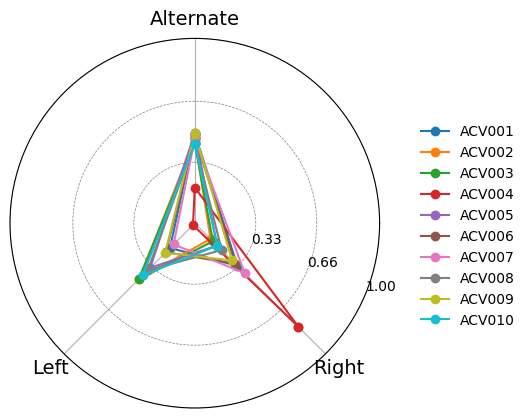

In [22]:

# Create polar plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
# Plot each subject in a polar plot
for subject in df_bias['subject'].unique():
    subject_data = df_bias[df_bias['subject'] == subject]
    
    # Extract the angles and distances
    angles = subject_data['bias_angle'].values
    percentages = subject_data['percentage'].values
    
    # Close the triangle by repeating the first point
    angles = np.append(angles, angles[0])
    percentages = np.append(percentages, percentages[0])
    
    # Plot the triangle
    ax.plot(angles, percentages, marker='o', linestyle='-', label=subject)
    
# Set title and formatting
# ax.set_title(f"Animal biases", va='bottom', fontsize=16)
ax.set_rlabel_position(-22.5)  # Adjust label position
ax.grid(True)

# make the circular 0.33 grid thicker
ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
# plot the 0.33 grid
ax.set_yticks([0.33, 0.66, 1.0])

ax.set_xticks([2*np.pi/4, 5*np.pi/4, 7*np.pi/4])
ax.set_xticklabels(['Alternate', 'Left', 'Right'], fontsize=14)

# Show the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.4, .8), ncol=1)
# remove border of legend box
plt.setp(ax.get_legend().get_frame(), linewidth=0)  # Set legend frame color and linewidth

plt.show()

<Axes: xlabel='first_choice'>

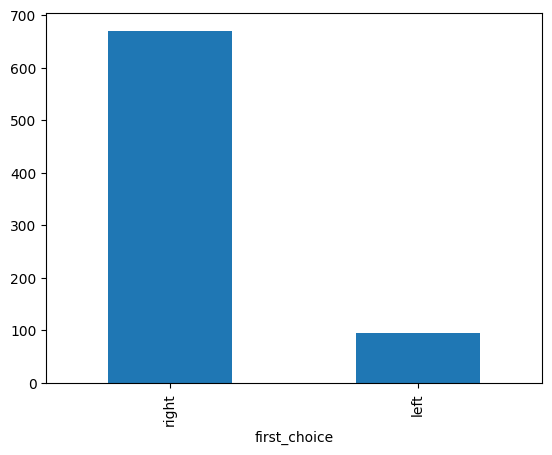

In [144]:
df[df.subject == "ACV004"].first_choice.value_counts().plot(kind='bar')

In [ ]:
#TODO: calculate reaction times per animal in 2AFC and show overlapping distributions
#TODO: show evolution of the reaction times per day, and the iti

Occupancy of the box

In [23]:
occupancy_df = dft.get_start_and_end_of_sessions_df(df)

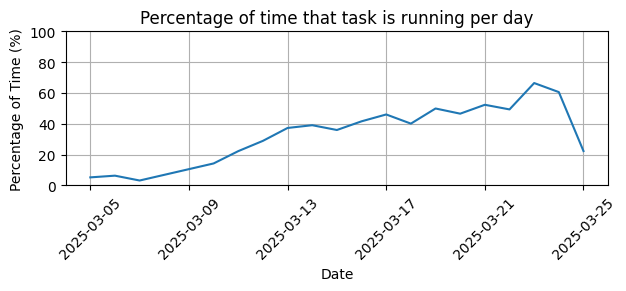

In [24]:
# Calculate the duration of each event in minutes
occupancy_df['duration'] = (occupancy_df['end_time'] - occupancy_df['start_time']).dt.total_seconds() / 60
# Group by date and calculate the total duration of events for each day
occupancy_df['date'] = occupancy_df['start_time'].dt.date
daily_durations = occupancy_df.groupby('date')['duration'].sum()
# Calculate the percentage of the day that the events occupy (1440 minutes in a day)
daily_percentages = (daily_durations / 1440) * 100

# Plot the percentage of time for each day
plt.figure(figsize=(7, 2))
daily_percentages.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Percentage of Time (%)')
plt.title('Percentage of time that task is running per day')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

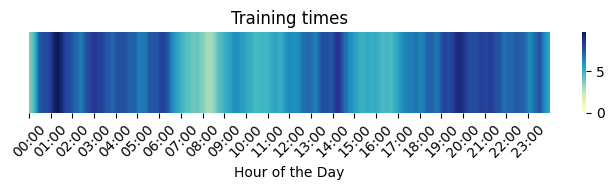

In [26]:
# Create a vector to represent the heatmap (1440 minutes in a day)
heatmap_vector = np.zeros(1440)

# Populate the heatmap vector with event occurrences
for start, end in zip(occupancy_df['start_time'], occupancy_df['end_time']):
    start_minute_of_day = start.hour * 60 + start.minute
    end_minute_of_day = end.hour * 60 + end.minute
    
    if start_minute_of_day <= end_minute_of_day:
        heatmap_vector[start_minute_of_day:end_minute_of_day] += 1
    else:
        heatmap_vector[start_minute_of_day:] += 1
        heatmap_vector[:end_minute_of_day] += 1

# smooth the heatmap vector
window_size = 60
heatmap_vector = np.convolve(heatmap_vector, np.ones(window_size)/window_size, mode='same')

# Plot the heatmap vector
plt.figure(figsize=(7, 2))
sns.heatmap(heatmap_vector.reshape(1, -1), cmap='YlGnBu', cbar=True, xticklabels=60, vmin=0, vmax=np.max(heatmap_vector))
plt.xlabel('Hour of the Day')
plt.ylabel('Event Occurrences')
plt.title('Training times')
# Set the x-ticks to show every hour
plt.xticks(ticks=np.arange(0, 1440, 60), labels=[f'{i//60:02d}:00' for i in range(0, 1440, 60)], rotation=45)
plt.yticks([])
plt.ylabel('')
plt.grid(False)
plt.tight_layout()
plt.show()

In [27]:
# Sort the dataframe by start_time
sorted_occupancy_df = occupancy_df.sort_values(by='start_time')

# Extract the ordered list of subject names
ordered_subjects = sorted_occupancy_df['subject'].tolist()

In [28]:
# 
def create_transition_matrix(events):
    # Initialize a matrix with zeros
    items = list(set(events))
    items.sort()  # Sort the items to ensure consistent ordering
    n = len(items)
    transition_matrix = np.zeros((n, n), dtype=int)
    
    # Map items to their indices in the matrix
    item_index = {item: i for i, item in enumerate(items)}
    
    # Count transitions from one item to the next
    for i in range(len(events) - 1):
        from_item = events[i]
        to_item = events[i + 1]
        transition_matrix[item_index[from_item], item_index[to_item]] += 1
    
    # Return the transition matrix as a pandas DataFrame for better readability
    return pd.DataFrame(transition_matrix, index=items, columns=items)

<Figure size 400x300 with 0 Axes>

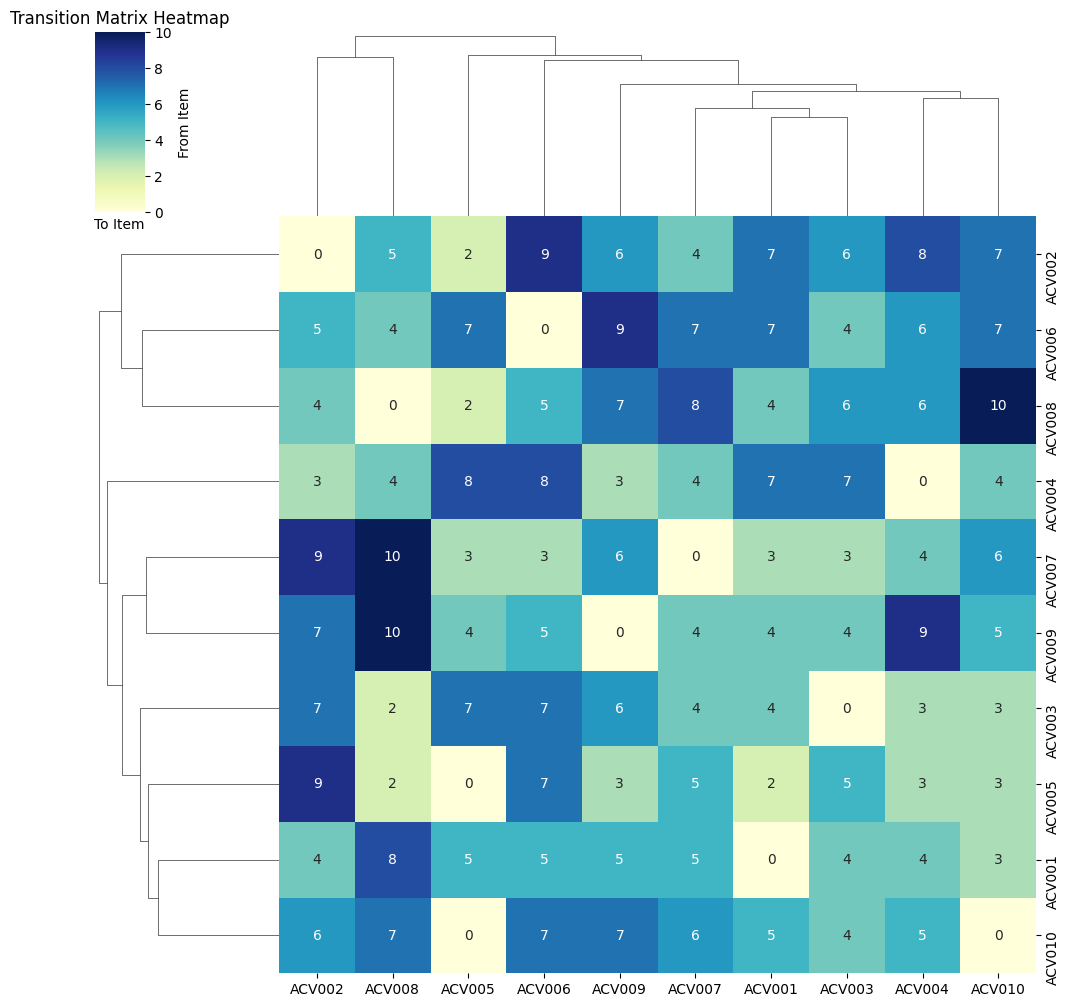

In [29]:
# plot the heatmap of the transition matrix with clustering
def plot_transition_matrix(transition_matrix):
    plt.figure(figsize=(4, 3))

    # sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
    sns.clustermap(transition_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, xticklabels=transition_matrix.columns, yticklabels=transition_matrix.index)
    plt.title('Transition Matrix Heatmap')
    plt.xlabel('To Item')
    plt.ylabel('From Item')
    plt.show()
# Create the transition matrix
transition_matrix = create_transition_matrix(ordered_subjects)
# cluster the transition matrix

# Plot the transition matrix
plot_transition_matrix(transition_matrix)

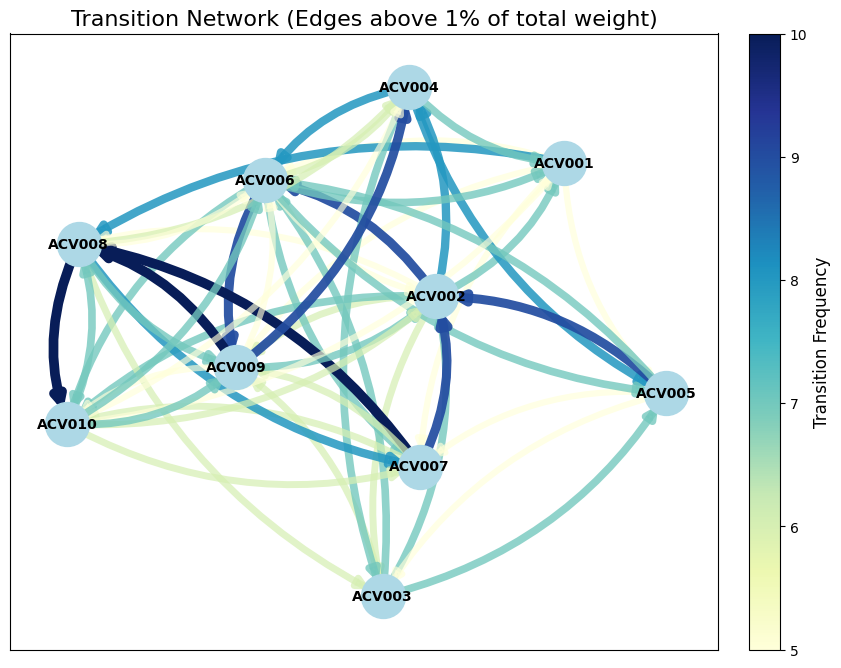

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_transition_network_with_curved_edges(transition_matrix, threshold=0):
    # Create a directed graph from the transition matrix
    G = nx.from_pandas_adjacency(transition_matrix, create_using=nx.DiGraph)
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency
    
    # Calculate total edge weight and filter edges above the threshold
    total_weight = sum(G[u][v]['weight'] for u, v in G.edges())
    min_weight = threshold * total_weight / 100  # Calculate the minimum weight based on % threshold
    
    plt.figure(figsize=(10, 8))
    
    # Edge attributes: Filter edges above the threshold and scale them
    filtered_edges = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= min_weight]
    edge_weights = [G[u][v]['weight'] for u, v in filtered_edges]
    
    # Normalize edge properties for filtered edges
    if edge_weights:
        max_weight = max(edge_weights)
    else:
        max_weight = 1  # Prevent division by zero if no edges remain
    
    edge_widths = [2 + (5 * G[u][v]['weight'] / max_weight) for u, v in filtered_edges]
    edge_alphas = [0.3 + (0.7 * G[u][v]['weight'] / max_weight) for u, v in filtered_edges]
    
    # Apply a colormap to the edges based on normalized weights
    norm = mcolors.Normalize(vmin=min(edge_weights, default=0), vmax=max_weight)
    edge_colors = [cm.YlGnBu(norm(G[u][v]['weight'])) for u, v in filtered_edges]
    
    # Draw larger, fully opaque nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', alpha=1.0)
    
    # Draw curved edges with varying properties, terminating early at the nodes
    for i, (u, v) in enumerate(filtered_edges):
        # Curve edges if they're bidirectional
        if G.has_edge(v, u) and (u, v) != (v, u):
            curve_scale = 0.2  # Add curvature for bidirectional edges
        else:
            curve_scale = 0
        
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=edge_widths[i], alpha=edge_alphas[i], edge_color=[edge_colors[i]],
            connectionstyle=f"arc3,rad={curve_scale}", arrows=True, arrowsize=15, arrowstyle='-|>',
            min_source_margin=10, min_target_margin=10,  # Terminate arrows earlier at the node edges
        )
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Transition Frequency', fontsize=12)

    plt.title(f'Transition Network (Edges above {threshold}% of total weight)', fontsize=16)
    plt.show()

# Example Usage:
# Show edges with weight greater than 10% of the total edge weight
plot_transition_network_with_curved_edges(transition_matrix, threshold=1)


In [ ]:

import altair as alt
import pandas as pd

# Sample data (replace with your actual dataset)
data = df_to_plot.copy()
# convert nans to 1
data['correct'] = data['correct'].fillna(1) * 100

In [ ]:
import altair as alt
import pandas as pd
import numpy as np

# Convert date to datetime format
data['year_month_day'] = pd.to_datetime(data['year_month_day'])

# Get min and max dates
min_date = data['year_month_day'].min()
max_date = data['year_month_day'].max()

# Create a list of all dates in the range
date_range = pd.date_range(start=min_date, end=max_date)
date_strings = [d.strftime('%Y-%m-%d') for d in date_range]

# Add a numeric field for the slider
data['date_index'] = data['year_month_day'].apply(
    lambda x: np.where(date_range == x)[0][0]
)

# Find global min and max values for x and y axes
min_trials = data['trials'].min()
max_trials = data['trials'].max()
min_correct = data['correct'].min()
max_correct = data['correct'].max()

# Add some padding to the axis limits (10%)
trials_padding = (max_trials - min_trials) * 0.1
correct_padding = (max_correct - min_correct) * 0.1

# Create a slider for date selection
date_slider = alt.binding_range(
    min=0,
    max=len(date_range)-1,
    step=1,
    name='Date: '
)

# Create a parameter that updates with the slider
date_selection = alt.param(
    name='date_idx',
    value=0,
    bind=date_slider
)

# Create a derived field for display purposes
slider_date = alt.expr.time(date_range[0].timestamp()*1000) + alt.expr.milliseconds(86400000 * date_selection)

# Hover selection for subjects
hover_selection = alt.selection_point(
    name='hover',
    on='mouseover', 
    fields=['subject'],
    empty=False
)

# Base chart encoding
base_encoding = dict(
    x=alt.X('trials:Q', 
            title='Number of Trials',
            scale=alt.Scale(domain=[min_trials - trials_padding, max_trials + trials_padding])),
    y=alt.Y('correct:Q', 
            title='Correct Choices (%)', 
            scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('current_training_stage:N', 
                    title='Training Stage',
                    legend=alt.Legend(orient='bottom', 
                                      titleFontSize=12, 
                                      labelFontSize=10))
)

# Main points filtered by current date
points = alt.Chart(data).mark_circle().encode(
    **base_encoding,
    size=alt.Size('trials:Q', title='Trials', scale=alt.Scale(range=[10, 200])),
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0.5)),
    tooltip=['subject', 'trials', 'correct', 'current_training_stage', 
             alt.Tooltip('year_month_day:T', title='Date')]
).transform_filter(
    alt.datum.date_index == date_selection
).add_params(hover_selection)

# Trajectories that appear on hover
trajectories = alt.Chart(data).mark_line(
    opacity=0.7,
    strokeWidth=2
).encode(
    **base_encoding,
    detail='subject:N',
    opacity=alt.condition(hover_selection, alt.value(0.8), alt.value(0))
).transform_filter(
    hover_selection
)

# All points for the selected subject (trajectory points)
trajectory_points = alt.Chart(data).mark_circle(
    size=80
).encode(
    **base_encoding,
    opacity=alt.condition(hover_selection, alt.value(0.8), alt.value(0)),
    tooltip=['subject', 'trials', 'correct', 'current_training_stage', 
             alt.Tooltip('year_month_day:T', title='Date')]
).transform_filter(
    hover_selection
)

# Date labels for trajectory points
date_labels = alt.Chart(data).mark_text(
    align='left',
    baseline='middle',
    dx=10,
    fontSize=10
).encode(
    **base_encoding,
    text='year_month_day:T',
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0))
).transform_filter(
    hover_selection
)

# Subject labels that appear on hover
subject_labels = alt.Chart(data).mark_text(
    align='center',
    baseline='bottom',
    dy=-10,
    fontSize=14,
    fontWeight='bold'
).encode(
    **base_encoding,
    text='subject:N',
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0))
).transform_filter(
    alt.datum.date_index == date_selection
).transform_filter(
    hover_selection
)

# Current date display
date_display = alt.Chart({'values': [{}]}).mark_text(
    align='right',
    baseline='top',
    fontSize=14,
    font='Arial',
    fontWeight='bold',
    dx=-10,
    dy=10
).encode(
    text=alt.Text(
        'yearmonthdate(datum.date):T',
        title='Current Date'
    ),
    x=alt.value(600),  # Right side of the chart
    y=alt.value(0)     # Top of the chart
).transform_calculate(
    date=slider_date
)

# Combine all layers
chart = alt.layer(
    points, 
    trajectories, 
    trajectory_points, 
    date_labels, 
    subject_labels, 
    date_display
).properties(
    width=600, 
    height=400,
    title='Subject Performance by Date'
).add_params(date_selection)

chart

In [ ]:
data['year_month_day']

In [ ]:
plt.hist(df.TRIAL_END - df.TRIAL_START, bins=500)
plt.show()

In [ ]:
df.columns